In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Install required libraries
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
# Unrar the dataset
!unrar x "/content/timage.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/timage.rar

Creating    train                                                     OK
Creating    train/Tomato___healthy                                    OK
Extracting  train/Tomato___healthy/1(10).JPG                               0%  OK 
Extracting  train/Tomato___healthy/1(100).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(102).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(105).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(106).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(107).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(108).JPG                              0%  OK 
Extracting  train/Tomato___healthy/1(11).JPG                               0%  OK 
Extra

In [ ]:
pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.2 MB/s eta 0:00:00


In [ ]:
import os
import patoolib

# Define the directory where you want to extract the RAR file
dataset_dir = './my_dataset_directory/'

# Create the directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Extract the RAR file into the dataset directory
patoolib.extract_archive('timage.rar', outdir=dataset_dir)

patool: Extracting timage.rar ...
patool: running /usr/bin/unrar x -- /content/timage.rar
patool:     with cwd='./my_dataset_directory/'
patool: ... timage.rar extracted to `./my_dataset_directory/'.


'./my_dataset_directory/'

In [ ]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
# Verify the content of the 'pimages' directory
extracted_images_dir = dataset_dir  # Assuming the 'pimages' directory is the extracted one
extracted_content = os.listdir(extracted_images_dir)

# Display the content of the 'pimages' directory
print("Content of 'timage.rar':", extracted_content)

Content of 'timage.rar': ['train']


In [ ]:
import os

# Assuming the 'train' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Get the list of subdirectories inside 'train'
subdirectories = [name for name in os.listdir(extracted_images_dir) if os.path.isdir(os.path.join(extracted_images_dir, name))]

# Display the content of the 'train' directory
print("Content of 'train':", os.listdir(extracted_images_dir))
print("Subdirectories inside 'train':", subdirectories)


Content of 'train': ['Tomato___healthy', 'Tomato___Late_blight']
Subdirectories inside 'train': ['Tomato___healthy', 'Tomato___Late_blight']


Content of 'train': ['Tomato___healthy', 'Tomato___Late_blight']


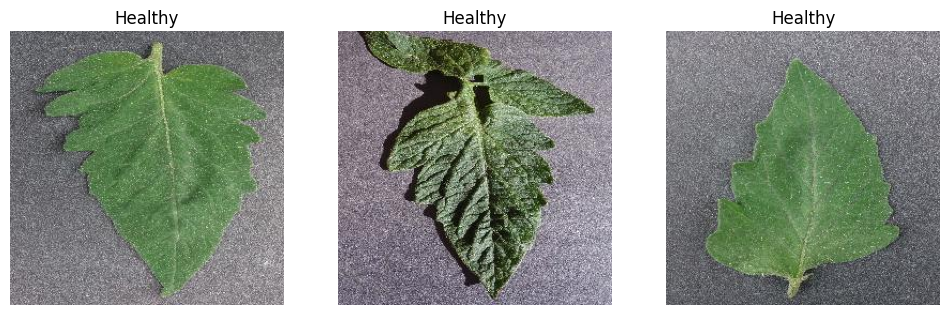

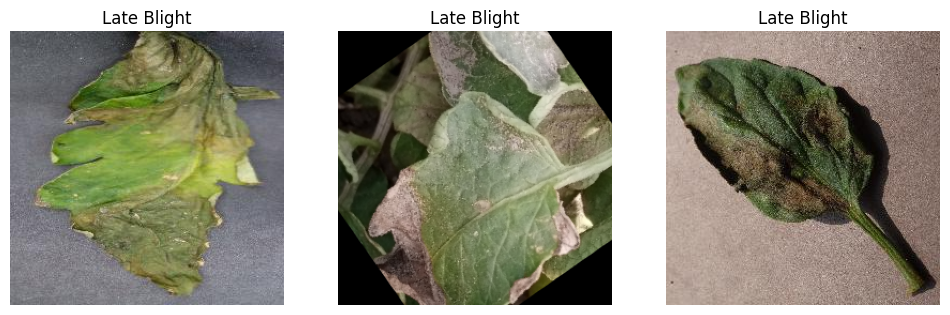

In [ ]:
import os
import matplotlib.pyplot as plt

# Assuming the 'train' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Display the content of the 'train' directory
extracted_content = os.listdir(extracted_images_dir)
print("Content of 'train':", extracted_content)

# Modify the paths to access the images inside subdirectories
subdir_path_healthy = os.path.join(extracted_images_dir, 'Tomato___healthy')
subdir_path_late_blight = os.path.join(extracted_images_dir, 'Tomato___Late_blight')

# List the images in the subdirectories
healthy_images = os.listdir(subdir_path_healthy)
late_blight_images = os.listdir(subdir_path_late_blight)

# Display images for 'Tomato___healthy'
plt.figure(figsize=(12, 6))
for i, image_name in enumerate(healthy_images[:3]):
    img_path = os.path.join(subdir_path_healthy, image_name)
    img = plt.imread(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Healthy')

# Display images for 'Tomato___Late_blight'
plt.figure(figsize=(12, 6))
for i, image_name in enumerate(late_blight_images[:3]):
    img_path = os.path.join(subdir_path_late_blight, image_name)
    img = plt.imread(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Late Blight')

plt.show()


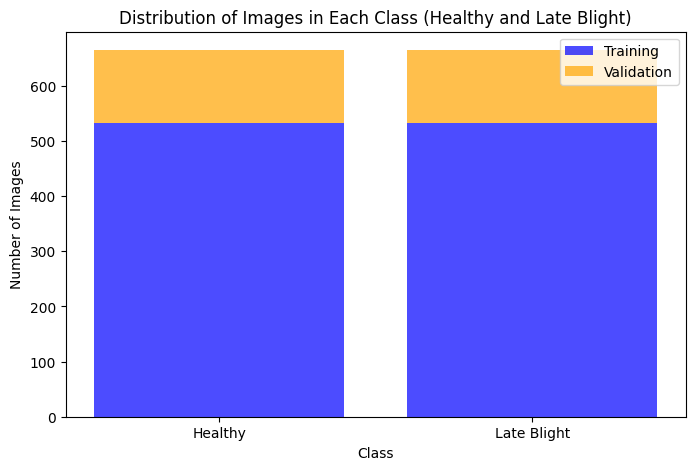

         Class  Training Images  Validation Images
0      Healthy              532                133
1  Late Blight              532                133


In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the 'train' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Define the subdirectories for healthy and late blight classes
healthy_subdir = 'Tomato___healthy'
late_blight_subdir = 'Tomato___Late_blight'

# Define the directories for training and validation
train_dir = 'tomato_disease_late_blight_train'
val_dir = 'tomato_disease_late_blight_val'

# Create directories for training and validation if they don't already exist
os.makedirs(os.path.join(train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'late_blight'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'late_blight'), exist_ok=True)

# Function to move images from source to destination directory
def move_images(src_dir, dst_dir, images):
    for image in images:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(dst_dir, image)
        shutil.move(src_path, dst_path)

# Get the list of all healthy and late blight images
healthy_images_dir = os.path.join(extracted_images_dir, healthy_subdir)
late_blight_images_dir = os.path.join(extracted_images_dir, late_blight_subdir)

healthy_images = os.listdir(healthy_images_dir)
late_blight_images = os.listdir(late_blight_images_dir)

# Shuffle the image lists
random.shuffle(healthy_images)
random.shuffle(late_blight_images)

# Split data into training and validation sets (80% - 20%)
train_split_idx_healthy = int(len(healthy_images) * 0.8)
train_split_idx_late_blight = int(len(late_blight_images) * 0.8)

train_images_healthy = healthy_images[:train_split_idx_healthy]
train_images_late_blight = late_blight_images[:train_split_idx_late_blight]

val_images_healthy = healthy_images[train_split_idx_healthy:]
val_images_late_blight = late_blight_images[train_split_idx_late_blight:]

# Move the training images to their respective directories
move_images(healthy_images_dir, os.path.join(train_dir, 'healthy'), train_images_healthy)
move_images(late_blight_images_dir, os.path.join(train_dir, 'late_blight'), train_images_late_blight)

# Move the validation images to their respective directories
move_images(healthy_images_dir, os.path.join(val_dir, 'healthy'), val_images_healthy)
move_images(late_blight_images_dir, os.path.join(val_dir, 'late_blight'), val_images_late_blight)

# Plot the distribution of images in each class
class_labels = ['Healthy', 'Late Blight']
train_counts = [len(train_images_healthy), len(train_images_late_blight)]
val_counts = [len(val_images_healthy), len(val_images_late_blight)]

plt.figure(figsize=(8, 5))
plt.bar(class_labels, train_counts, label='Training', color='blue', alpha=0.7)
plt.bar(class_labels, val_counts, bottom=train_counts, label='Validation', color='orange', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class (Healthy and Late Blight)')
plt.legend()
plt.show()

# Create a summary table for the dataset
data = {
    'Class': class_labels,
    'Training Images': train_counts,
    'Validation Images': val_counts
}

df = pd.DataFrame(data)
print(df)


CNN Model and train model

Found 1064 images belonging to 2 classes.
Found 266 images belonging to 2 classes.
Epoch 1/10
34/34 [==============================] - 57s 2s/step - loss: 0.6513 - accuracy: 0.6259 - val_loss: 0.6131 - val_accuracy: 0.6053
Epoch 2/10
34/34 [==============================] - 48s 1s/step - loss: 0.4511 - accuracy: 0.7998 - val_loss: 0.2350 - val_accuracy: 0.9135
Epoch 3/10
34/34 [==============================] - 49s 1s/step - loss: 0.3438 - accuracy: 0.8487 - val_loss: 0.4038 - val_accuracy: 0.8008
Epoch 4/10
34/34 [==============================] - 50s 1s/step - loss: 0.2629 - accuracy: 0.8985 - val_loss: 0.0689 - val_accuracy: 0.9737
Epoch 5/10
34/34 [==============================] - 45s 1s/step - loss: 0.2303 - accuracy: 0.9032 - val_loss: 0.0847 - val_accuracy: 0.9737
Epoch 6/10
34/34 [==============================] - 46s 1s/step - loss: 0.1440 - accuracy: 0.9483 - val_loss: 0.0716 - val_accuracy: 0.9662
Epoch 7/10
34/34 [==============================] - 51s 1s/step - loss: 0.188

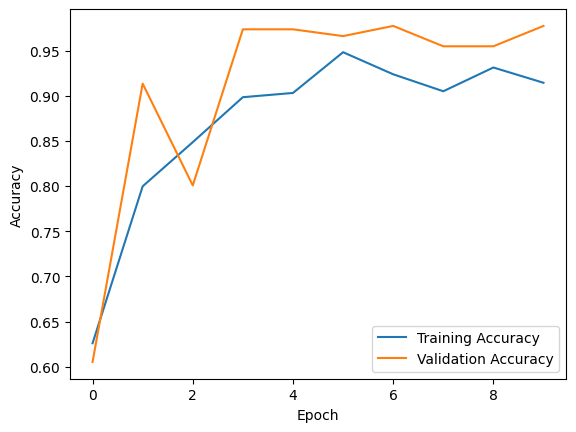

         Class  Training Images  Validation Images
0      Healthy                0                  0
1  Late Blight                0                  0


In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the 'train' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Define the subdirectories for healthy and late blight classes
healthy_subdir = 'Tomato___healthy'
late_blight_subdir = 'Tomato___Late_blight'

# Define the directories for training and validation
train_dir = 'tomato_disease_late_blight_train'
val_dir = 'tomato_disease_late_blight_val'

# Create directories for training and validation if they don't already exist
os.makedirs(os.path.join(train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'late_blight'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'late_blight'), exist_ok=True)

# Function to move images from source to destination directory
def move_images(src_dir, dst_dir, images):
    for image in images:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(dst_dir, image)
        shutil.move(src_path, dst_path)

# Get the list of all healthy and late blight images
healthy_images_dir = os.path.join(extracted_images_dir, healthy_subdir)
late_blight_images_dir = os.path.join(extracted_images_dir, late_blight_subdir)

healthy_images = os.listdir(healthy_images_dir)
late_blight_images = os.listdir(late_blight_images_dir)

# Shuffle the image lists
random.shuffle(healthy_images)
random.shuffle(late_blight_images)

# Split data into training and validation sets (80% - 20%)
train_split_idx_healthy = int(len(healthy_images) * 0.8)
train_split_idx_late_blight = int(len(late_blight_images) * 0.8)

train_images_healthy = healthy_images[:train_split_idx_healthy]
train_images_late_blight = late_blight_images[:train_split_idx_late_blight]

val_images_healthy = healthy_images[train_split_idx_healthy:]
val_images_late_blight = late_blight_images[train_split_idx_late_blight:]

# Move the training images to their respective directories
move_images(healthy_images_dir, os.path.join(train_dir, 'healthy'), train_images_healthy)
move_images(late_blight_images_dir, os.path.join(train_dir, 'late_blight'), train_images_late_blight)

# Move the validation images to their respective directories
move_images(healthy_images_dir, os.path.join(val_dir, 'healthy'), val_images_healthy)
move_images(late_blight_images_dir, os.path.join(val_dir, 'late_blight'), val_images_late_blight)

# Image size and batch size for the CNN model
img_size = (128, 128)
batch_size = 32

# Create a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Healthy or Late Blight
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

# No data augmentation for the validation set
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Flow images from directories and generate batches of augmented data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                                    batch_size=batch_size, class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size,
                                                batch_size=batch_size, class_mode='binary')

# Training the model
epochs = 10
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=epochs, validation_data=val_generator,
                    validation_steps=len(val_generator))

# Evaluate the model on the validation set
print("Evaluate the model on the validation set:")
model.evaluate(val_generator)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create a summary table for the dataset
class_labels = ['Healthy', 'Late Blight']
train_counts = [len(train_images_healthy), len(train_images_late_blight)]
val_counts = [len(val_images_healthy), len(val_images_late_blight)]

data = {
    'Class': class_labels,
    'Training Images': train_counts,
    'Validation Images': val_counts
}

df = pd.DataFrame(data)
print(df)


**Zero-shot learning CNN MODEL**

58889256/58889256 [==============================] - 1s 0us/step
Found 1064 images belonging to 2 classes.
Found 266 images belonging to 2 classes.
Epoch 1/10
34/34 [==============================] - 299s 9s/step - loss: 0.5385 - accuracy: 0.7133 - val_loss: 0.4573 - val_accuracy: 0.7707
Epoch 2/10
34/34 [==============================] - 267s 8s/step - loss: 0.3741 - accuracy: 0.8383 - val_loss: 0.3910 - val_accuracy: 0.8045
Epoch 3/10
34/34 [==============================] - 300s 9s/step - loss: 0.3103 - accuracy: 0.8722 - val_loss: 0.3161 - val_accuracy: 0.8534
Epoch 4/10
34/34 [==============================] - 303s 9s/step - loss: 0.2837 - accuracy: 0.8957 - val_loss: 0.2684 - val_accuracy: 0.8835
Epoch 5/10
34/34 [==============================] - 303s 9s/step - loss: 0.2609 - accuracy: 0.8994 - val_loss: 0.2851 - val_accuracy: 0.8534
Epoch 6/10
34/34 [==============================] - 304s 9s/step - loss: 0.2544 - accuracy: 0.8929 - val_loss: 0.2351 - val_accuracy: 0.9023
Epoch 

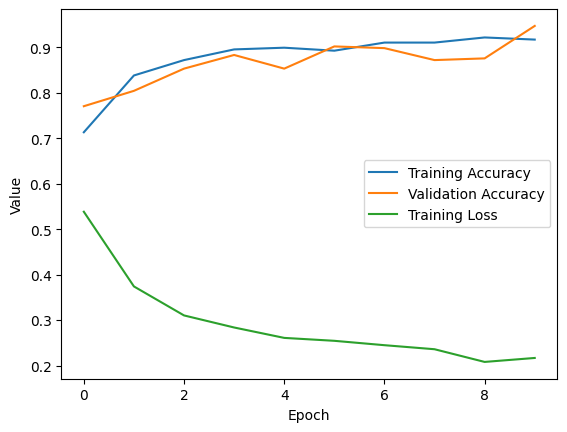

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the 'train' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Define the subdirectories for healthy and late blight classes
healthy_subdir = 'Tomato___healthy'
late_blight_subdir = 'Tomato___Late_blight'

# ... Rest of the code remains unchanged ...

# Image size and batch size for the CNN model
img_size = (128, 128)
batch_size = 32

# Load your dataset containing attributes for each class (attributes_train, attributes_val, attributes_test)

# Load the VGG16 model with pre-trained weights (without the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Global Average Pooling to reduce dimensions
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dense layer with the number of attributes as output units
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add a final dense layer with the number of classes (2: healthy and late blight)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Zero-shot learning using the attributes

# Create the zero-shot learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

# No data augmentation for the validation set
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Flow images from directories and generate batches of augmented data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                                    batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size,
                                                batch_size=batch_size, class_mode='categorical')

# Training the model
epochs = 10
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=epochs, validation_data=val_generator,
                    validation_steps=len(val_generator))

# Evaluate the model on the validation set
print("Evaluate the model on the validation set:")
model.evaluate(val_generator)

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')  # Adding loss plot
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


Found 1330 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 6s 98ms/step - loss: 0.6500 - accuracy: 0.6383
Epoch 2/50
42/42 [==============================] - 4s 85ms/step - loss: 0.4192 - accuracy: 0.8045
Epoch 3/50
42/42 [==============================] - 4s 103ms/step - loss: 0.2297 - accuracy: 0.9015
Epoch 4/50
42/42 [==============================] - 4s 85ms/step - loss: 0.1753 - accuracy: 0.9248
Epoch 5/50
42/42 [==============================] - 4s 86ms/step - loss: 0.1357 - accuracy: 0.9459
Epoch 6/50
42/42 [==============================] - 5s 120ms/step - loss: 0.0962 - accuracy: 0.9632
Epoch 7/50
42/42 [==============================] - 4s 85ms/step - loss: 0.2093 - accuracy: 0.9211
Epoch 8/50
42/42 [==============================] - 4s 85ms/step - loss: 0.1211 - accuracy: 0.9579
Epoch 9/50
42/42 [==============================] - 5s 118ms/step - loss: 0.0662 - accuracy: 0.9759
Epoch 10/50
42/42 [==============================] - 4s 84ms/ste

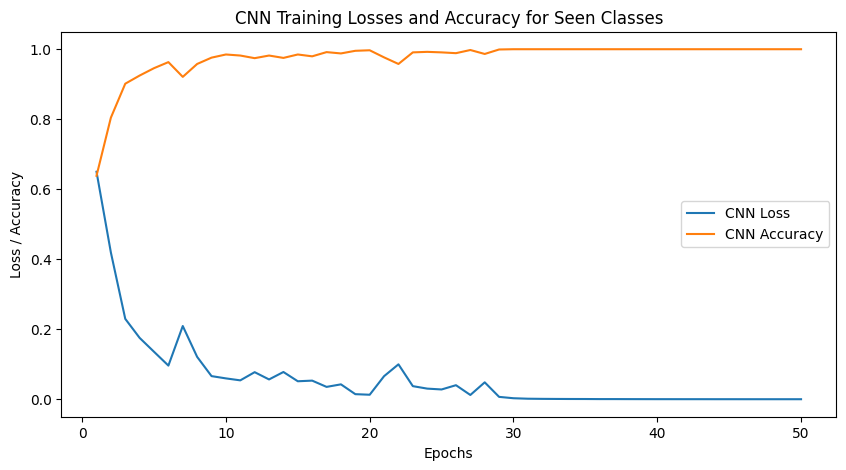

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define image dimensions
image_width = 32
image_height = 32

# Define batch size
batch_size = 32

# Load your dataset using ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255)

# Training data generator for seen classes
train_path_seen = 'train'  # Update the path to the directory with seen classes images
train_generator_seen = train_data_gen.flow_from_directory(
    train_path_seen,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical class mode for multi-class classification
    shuffle=True
)

# Get the number of classes from the generator
num_classes = len(train_generator_seen.class_indices)

# Define the CNN model architecture for seen classes
cnn_input = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
cnn_output = Dense(num_classes, activation='softmax')(x)
cnn_model = Model(cnn_input, cnn_output)

# Compile the CNN model
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the CNN model for seen classes
cnn_epochs = 50  # You can adjust the number of epochs as needed
cnn_history = cnn_model.fit(train_generator_seen, epochs=cnn_epochs, verbose=1)

# Plot the CNN training losses and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, cnn_epochs + 1), cnn_history.history['loss'], label='CNN Loss')
plt.plot(range(1, cnn_epochs + 1), cnn_history.history['accuracy'], label='CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('CNN Training Losses and Accuracy for Seen Classes')
plt.legend()
plt.show()


In [ ]:
CNN ZERO SHOT UNSEEN

**CNN ZERO SHOT UNSEEN**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

# ... (Rest of the code as before)

# Define the CNN model architecture for seen classes (modified for binary classification)
cnn_input = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
cnn_output = Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification
cnn_model = Model(cnn_input, cnn_output)

# Compile the CNN model
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the CNN model for seen classes
cnn_epochs = 50  # You can adjust the number of epochs as needed
cnn_history = cnn_model.fit(train_generator_seen, epochs=cnn_epochs, verbose=1)

# Create a table to display the training progress
training_progress_cnn = pd.DataFrame({'Epoch': range(1, cnn_epochs + 1),
                                      'Loss': cnn_history.history['loss'],
                                      'Accuracy': cnn_history.history['accuracy']})

print(training_progress_cnn)


Epoch 1/50
42/42 [==============================] - 6s 86ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 2/50
42/42 [==============================] - 4s 84ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 3/50
42/42 [==============================] - 5s 107ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/50
42/42 [==============================] - 4s 85ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/50
42/42 [==============================] - 4s 84ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 6/50
42/42 [==============================] - 4s 97ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 7/50
42/42 [==============================] - 4s 84ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 8/50
42/42 [==============================] - 5s 117ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 9/50
42/42 [==============================] - 4s 84ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 10/50
42/42 [==============================] - 4s 85ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 1

Found 1330 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 8s 132ms/step - loss: 0.6614 - accuracy: 0.6203
Epoch 2/50
42/42 [==============================] - 6s 148ms/step - loss: 0.4377 - accuracy: 0.7992
Epoch 3/50
42/42 [==============================] - 4s 88ms/step - loss: 0.2732 - accuracy: 0.8910
Epoch 4/50
42/42 [==============================] - 5s 121ms/step - loss: 0.2236 - accuracy: 0.9173
Epoch 5/50
42/42 [==============================] - 4s 91ms/step - loss: 0.2084 - accuracy: 0.9203
Epoch 6/50
42/42 [==============================] - 4s 90ms/step - loss: 0.1302 - accuracy: 0.9556
Epoch 7/50
42/42 [==============================] - 4s 86ms/step - loss: 0.1111 - accuracy: 0.9571
Epoch 8/50
42/42 [==============================] - 5s 122ms/step - loss: 0.0910 - accuracy: 0.9677
Epoch 9/50
42/42 [==============================] - 4s 88ms/step - loss: 0.1032 - accuracy: 0.9647
Epoch 10/50
42/42 [==============================] - 4s 101ms/s

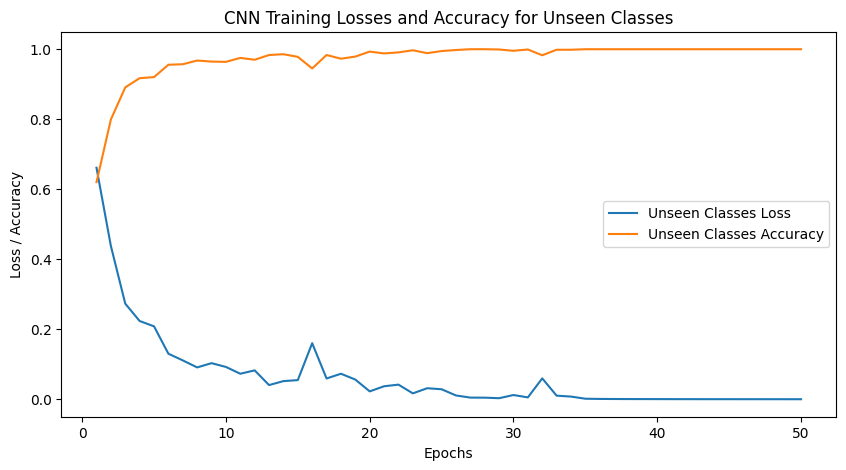

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define image dimensions
image_width = 32
image_height = 32

# Define batch size
batch_size = 32

# Load your dataset using ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255)

# Training data generator for both seen and unseen classes (use the same path)
train_path_seen_unseen = 'train'  # Update the path to the directory with both seen and unseen classes images
train_generator_seen_unseen = train_data_gen.flow_from_directory(
    train_path_seen_unseen,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical class mode for multi-class classification
    shuffle=True
)

# Get the number of classes from the generator
num_classes = len(train_generator_seen_unseen.class_indices)

# Define the CNN model architecture for unseen classes
cnn_input = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
cnn_output_unseen = Dense(num_classes, activation='softmax')(x)  # Output for unseen classes
cnn_model_unseen = Model(cnn_input, cnn_output_unseen)

# Compile the CNN model for unseen classes
cnn_model_unseen.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Specify the number of epochs for training on unseen classes
cnn_epochs_unseen = 50  # You can adjust the number of epochs as needed

# Train the CNN model for unseen classes
cnn_history_unseen = cnn_model_unseen.fit(train_generator_seen_unseen, epochs=cnn_epochs_unseen, verbose=1)

# Plot the CNN training losses and accuracy for unseen classes
plt.figure(figsize=(10, 5))
plt.plot(range(1, cnn_epochs_unseen + 1), cnn_history_unseen.history['loss'], label='Unseen Classes Loss')
plt.plot(range(1, cnn_epochs_unseen + 1), cnn_history_unseen.history['accuracy'], label='Unseen Classes Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('CNN Training Losses and Accuracy for Unseen Classes')
plt.legend()
plt.show()  # Add this line to display the plot


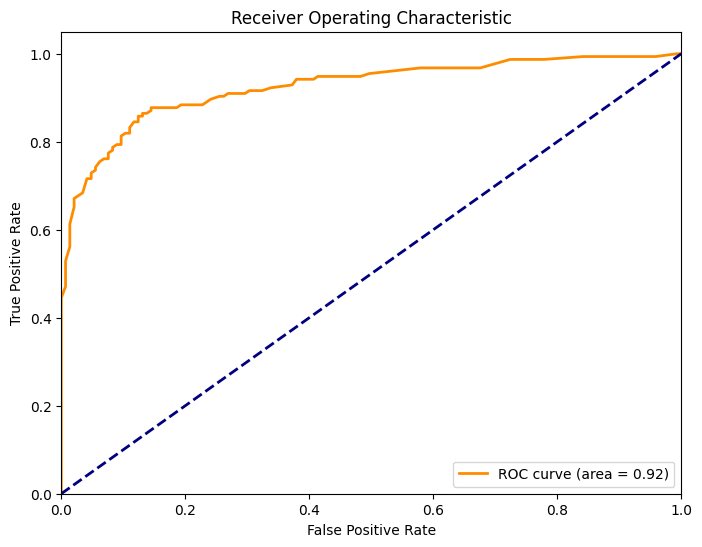

AUC: 0.9244493882091211


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generate example data (you should replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier (you should replace this with your actual classifier)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", roc_auc)


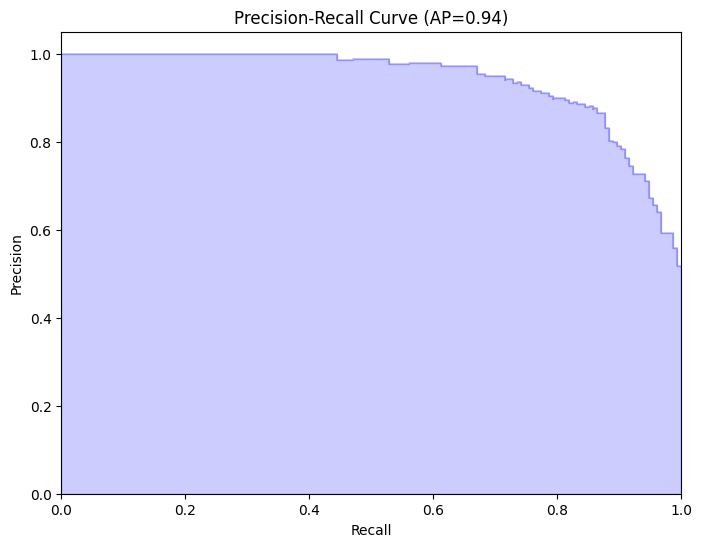

Average Precision: 0.9404891583658183


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generate example data (you should replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier (you should replace this with your actual classifier)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.show()

print("Average Precision:", average_precision)


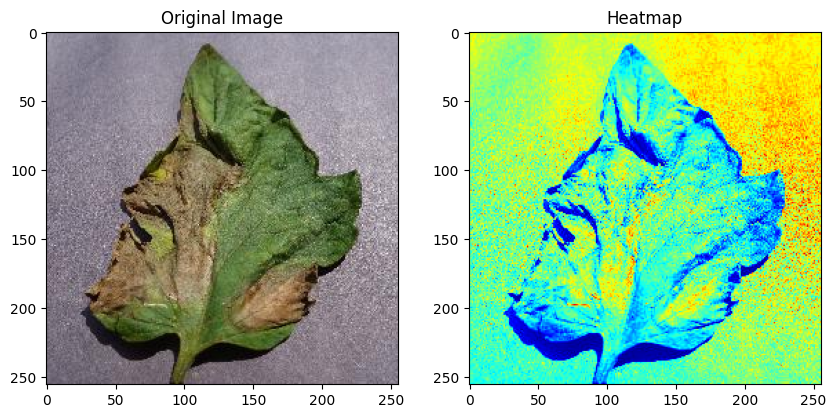

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/train/Tomato___Late_blight/1(1).JPG'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create the heatmap
heatmap = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

# Display the original image and heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title('Heatmap')

plt.show()


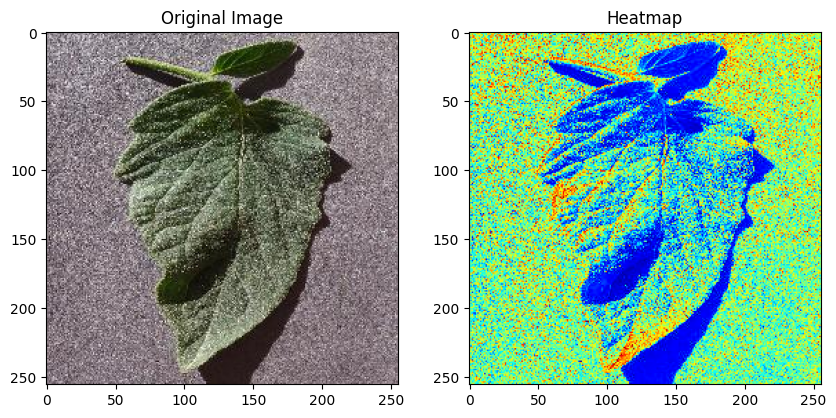

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/train/Tomato___healthy/1(10).JPG'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create the heatmap
heatmap = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

# Display the original image and heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title('Heatmap')

plt.show()


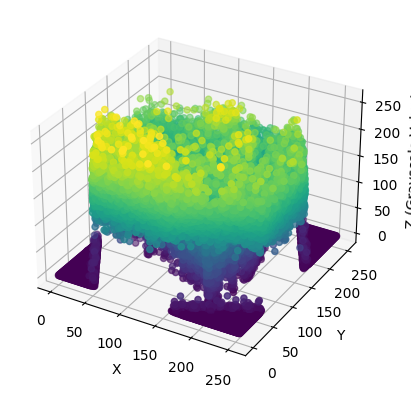

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Load the image
image_path = '/content/train/Tomato___healthy/1(102).JPG'
image = Image.open(image_path)

# Get the dimensions of the image
width, height = image.size

# Create 3D scatter plot data
x = []
y = []
z = []

for i in range(width):
    for j in range(height):
        pixel_color = image.getpixel((i, j))
        x.append(i)
        y.append(j)
        z.append(sum(pixel_color) / 3)  # Use grayscale value as z-coordinate

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Grayscale Value)')

# Show the plot
plt.show()


Found 1064 images belonging to 2 classes.
Found 266 images belonging to 2 classes.
Epoch 1/10
34/34 [==============================] - 306s 9s/step - loss: 0.5514 - accuracy: 0.7218 - val_loss: 0.3904 - val_accuracy: 0.8383
Epoch 2/10
34/34 [==============================] - 268s 8s/step - loss: 0.3447 - accuracy: 0.8571 - val_loss: 0.3870 - val_accuracy: 0.8233
Epoch 3/10
34/34 [==============================] - 270s 8s/step - loss: 0.3113 - accuracy: 0.8675 - val_loss: 0.3480 - val_accuracy: 0.8346
Epoch 4/10
34/34 [==============================] - 293s 9s/step - loss: 0.2755 - accuracy: 0.8947 - val_loss: 0.2788 - val_accuracy: 0.8797
Epoch 5/10
34/34 [==============================] - 292s 9s/step - loss: 0.2707 - accuracy: 0.8863 - val_loss: 0.2826 - val_accuracy: 0.8759
Epoch 6/10
34/34 [==============================] - 260s 8s/step - loss: 0.2562 - accuracy: 0.8872 - val_loss: 0.2582 - val_accuracy: 0.8797
Epoch 7/10
34/34 [==============================] - 292s 9s/step - loss

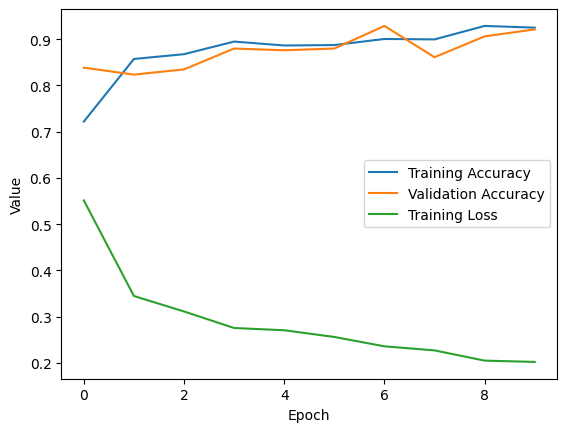

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming the 'pimages' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Define the subdirectories for healthy and early blight classes
healthy_subdir = 'Tomato___healthy'
early_blight_subdir = 'Tomato___Late_blight'

# ... Rest of the code remains unchanged ...

# Image size and batch size for the CNN model
img_size = (128, 128)
batch_size = 32

# Load your dataset containing attributes for each class (attributes_train, attributes_val, attributes_test)

# Load the VGG16 model with pre-trained weights (without the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Global Average Pooling to reduce dimensions
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dense layer with the number of attributes as output units
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add a final dense layer with the number of classes (2: healthy and early blight)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Zero-shot learning using the attributes

# Create the zero-shot learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

# No data augmentation for the validation set
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Flow images from directories and generate batches of augmented data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                                    batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size,
                                                batch_size=batch_size, class_mode='categorical')

# Training the model
epochs = 10
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=epochs, validation_data=val_generator,
                    validation_steps=len(val_generator))

# Evaluate the model on the validation set
print("Evaluate the model on the validation set:")
val_pred = model.predict(val_generator)
val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = val_generator.classes

# Calculate accuracy
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(val_true_labels, val_pred_labels)
print("Precision:", precision)

# Calculate recall
recall = recall_score(val_true_labels, val_pred_labels)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(val_true_labels, val_pred_labels)
print("F1 Score:", f1)

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')  # Adding loss plot
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


Evaluate the model on the validation set:
9/9 [==============================] - 57s 6s/step


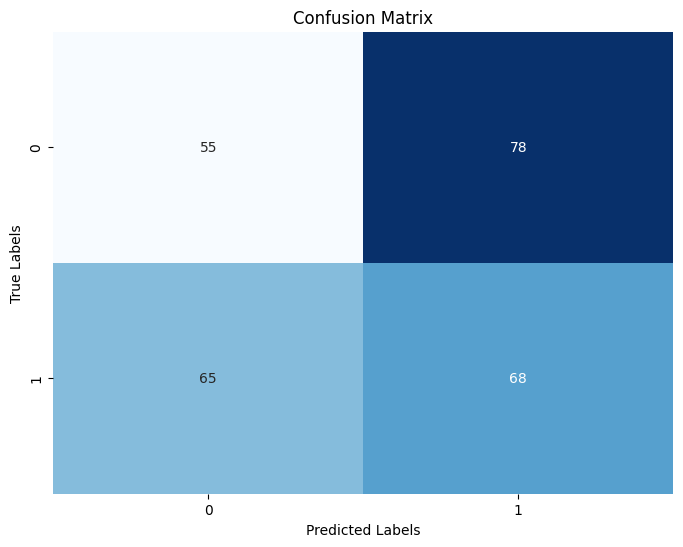

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the 'pimages' directory is the extracted one
extracted_images_dir = './my_dataset_directory/train/'

# Define the subdirectories for healthy and early blight classes
healthy_subdir = 'Tomato___healthy'
early_blight_subdir = 'Tomato___Late_blight'

# ... Rest of the code remains unchanged ...

# Function to preprocess images for VGG16
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# ... Your previous code ...

# Evaluate the model on the validation set
print("Evaluate the model on the validation set:")
val_pred = model.predict(val_generator)
val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
